In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
#from xgcm.autogenerate import generate_grid_ds
from functools import partial
from scipy.signal import butter, filtfilt
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from dask.distributed import Client, LocalCluster
    #
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 128,Total memory: 251.08 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38695,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 128
Started: Just now,Total memory: 251.08 GiB
Comm: tcp://127.0.0.1:38425,Total threads: 8
Dashboard: http://127.0.0.1:38777/status,Memory: 15.69 GiB
Nanny: tcp://127.0.0.1:36777,


In [7]:
out_dir_zarr = '/meddy/yuxlong5/data/data_rechunk/'

grid = xr.open_dataset('/meddy/yuxlong5/data/data_zarr/Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_zarr+'U_total_rechunk.zarr').rename({'lon_g': 'lon'})
ds_V = xr.open_zarr(out_dir_zarr+'V_total_rechunk.zarr').rename({'lat_g': 'lat'})
ds = xr.merge([ds_U,ds_V,grid])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (time: 9415, depth: 52, lat: 201, lon: 177, lat_g: 201, lon_g: 177)
Coordinates: (12/21)
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lon      (lon) float32 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * lat      (lat) float32 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
    XC       (lat, lon) float32 ...
    YC       (lat, lon) float32 ...
    ...       ...
    rA       (lat, lon) float32 ...
    rAz      (lat_g, lon_g) float32 ...
    rAw      (lat, lon_g) float32 ...
    rAs      (lat_g, lon) float32 ...
  * lat_g    (lat_g) float32 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
  * lon_g    (lon_g) float32 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
Data variables:
    U        (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 1, 177), meta=np.ndarray>
    V        (time, depth, lat, lon) float32 dask.

In [8]:
out_dir_result = '/meddy/yuxlong5/data/result/'

def butter_filter(x, b, a):
    return xr.apply_ufunc(partial(filtfilt, b, a),
                          x.chunk(),
                          dask='parallelized',
                          output_dtypes=[x.dtype],
                          kwargs={'axis': 0})

## (1) bandpass (M2 band)

In [9]:
lowcut = 1/13.8/3600
highcut = 1/11.2/3600

fs = 1/3600
nyq = 0.5*fs
low = lowcut/nyq
high = highcut/nyq

b, a = butter(4, [low, high], 'bandpass')

In [23]:
U_bandpass_filter = butter_filter(ds.U, b, a)
V_bandpass_filter = butter_filter(ds.V, b, a)

KE_bandpass_filter = 1025*(U_bandpass_filter**2 + V_bandpass_filter**2)/2 # KE
print(KE_bandpass_filter)

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<truediv, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lon      (lon) float32 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * lat      (lat) float32 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
    XC       (lat, lon) float32 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    YC       (lat, lon) float32 47.4 47.4 47.4 47.4 ... 49.99 49.99 49.99 49.99
    CS       (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    SN       (lat, lon) float32 -2.519e-13 -0.0 -0.0 ... 2.653e-13 -2.652e-13
    Depth    (lat, lon) float32 4.659e+03 4.648e+03 ... 4.07e+03 4.057e+03
    rA       (lat, lon) float32 2.302e+06 2.302e+06 ... 2.09e+06 2.09e+06


In [24]:
# It takes 10-20 mins
KE_bandpass_filter = np.real(KE_bandpass_filter).rename('KE_bandpass_filter')
file_out = out_dir_result+'/KE_bandpass_m2.zarr'
KE_bandpass_filter.to_dataset().to_zarr(file_out, mode='w')   

In [10]:
U_bandpass_filter = butter_filter(ds.U, b, a)
V_bandpass_filter = butter_filter(ds.V, b, a)

KE_bandpass_filter = 1025*(U_bandpass_filter**2 + V_bandpass_filter**2)/2 # KE
KE_bandpass_filter_tmean = KE_bandpass_filter.mean(['time'])
print(KE_bandpass_filter_tmean)

<xarray.DataArray (depth: 52, lat: 201, lon: 177)>
dask.array<mean_agg-aggregate, shape=(52, 201, 177), dtype=float32, chunksize=(1, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lon      (lon) float32 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * lat      (lat) float32 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
    XC       (lat, lon) float32 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    YC       (lat, lon) float32 47.4 47.4 47.4 47.4 ... 49.99 49.99 49.99 49.99
    CS       (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    SN       (lat, lon) float32 -2.519e-13 -0.0 -0.0 ... 2.653e-13 -2.652e-13
    Depth    (lat, lon) float32 4.659e+03 4.648e+03 ... 4.07e+03 4.057e+03
    rA       (lat, lon) float32 2.302e+06 2.302e+06 ... 2.09e+06 2.09e+06


In [11]:
# It takes 10-20 mins
KE_bandpass_filter_tmean = np.real(KE_bandpass_filter_tmean).rename('KE_bandpass_filter_tmean')
file_out = out_dir_result+'/KE_m2_tmean.zarr'
KE_bandpass_filter_tmean.to_dataset().to_zarr(file_out, mode='w')   

In [12]:
ds_m2 = xr.open_zarr(out_dir_result+'KE_m2_tmean.zarr')
ds_m2

<xarray.Dataset>
Dimensions:                   (lat: 201, lon: 177, depth: 52)
Coordinates:
    CS                        (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    Depth                     (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    SN                        (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    XC                        (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    YC                        (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
  * depth                     (depth) float64 0.5 1.57 2.79 ... 945.6 992.3
  * lat                       (lat) float32 47.4 47.42 47.43 ... 49.98 49.99
  * lon                       (lon) float32 -18.03 -18.01 ... -14.39 -14.36
    rA                        (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
Data variables:
    KE_bandpass_filter_tmean  (depth, lat, lon) float32 dask.array<chunksize=(1, 1, 177), meta=np.ndarray>

In [25]:
ds_m2 = xr.open_zarr(out_dir_result+'KE_bandpass_m2.zarr')
ds_m2

<xarray.Dataset>
Dimensions:             (lat: 201, lon: 177, time: 9415, depth: 52)
Coordinates:
    CS                  (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    Depth               (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    SN                  (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    XC                  (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    YC                  (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
  * depth               (depth) float64 0.5 1.57 2.79 ... 900.1 945.6 992.3
  * lat                 (lat) float32 47.4 47.42 47.43 ... 49.96 49.98 49.99
  * lon                 (lon) float32 -18.03 -18.01 -17.99 ... -14.39 -14.36
    rA                  (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
  * time                (time) float64 0.0 0.04167 0.08333 ... 392.2 392.2 392.2
Data variables:
    KE_bandpass_filter  (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 1, 177), meta=np.ndarray>

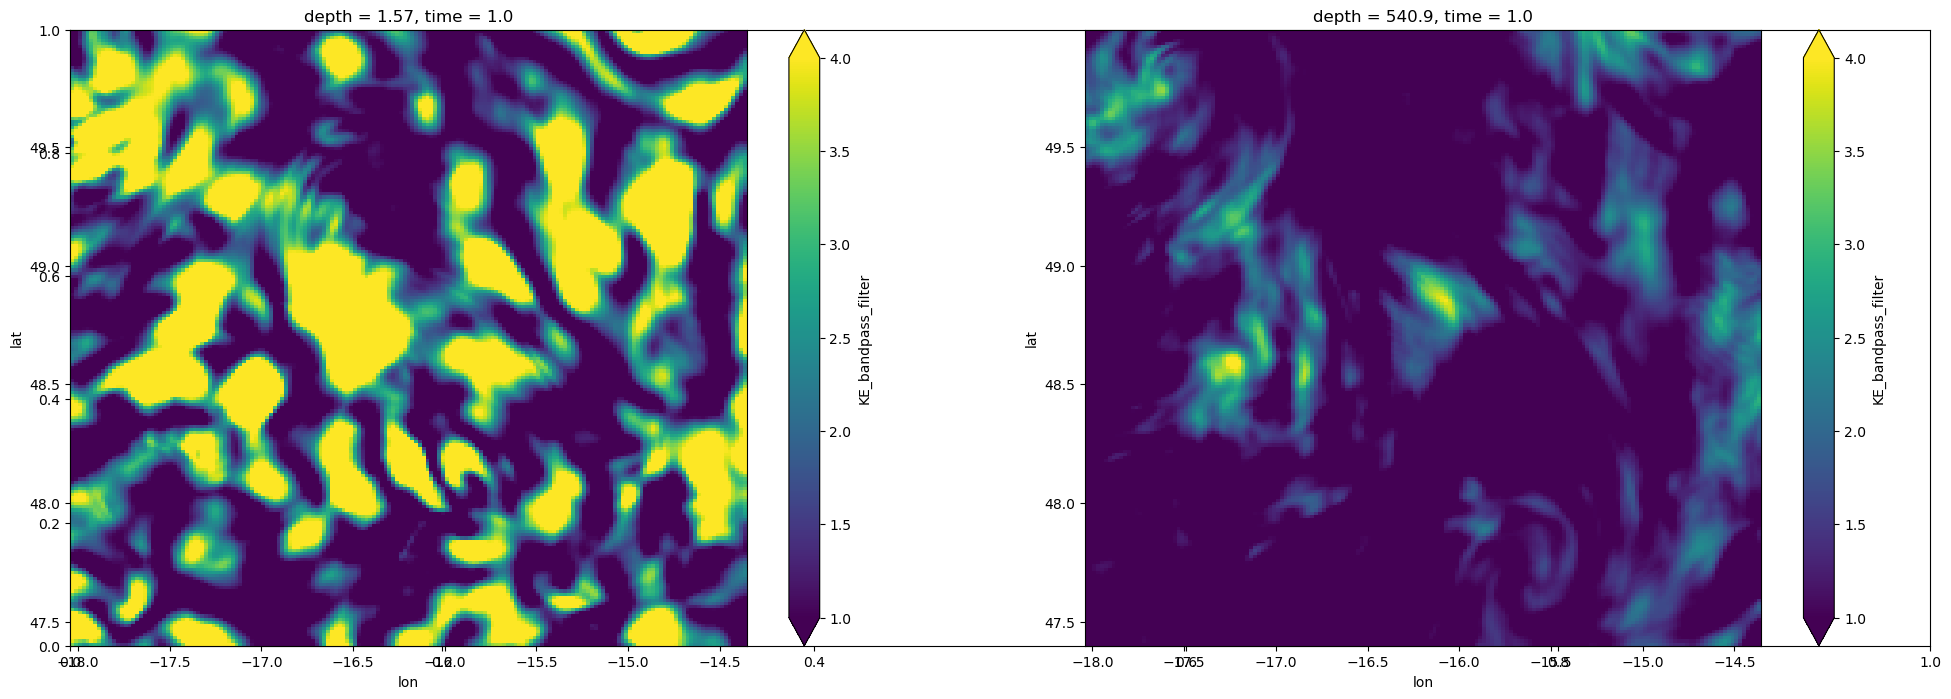

In [29]:
fig, ax = plt.subplots(figsize=(24,8))

ax = plt.subplot(121)
ds_m2.KE_bandpass_filter.isel(depth=1,time=24).plot(vmin=1,vmax=4)

ax = plt.subplot(122)
ds_m2.KE_bandpass_filter.isel(depth=40,time=24).plot(vmin=1,vmax=4)


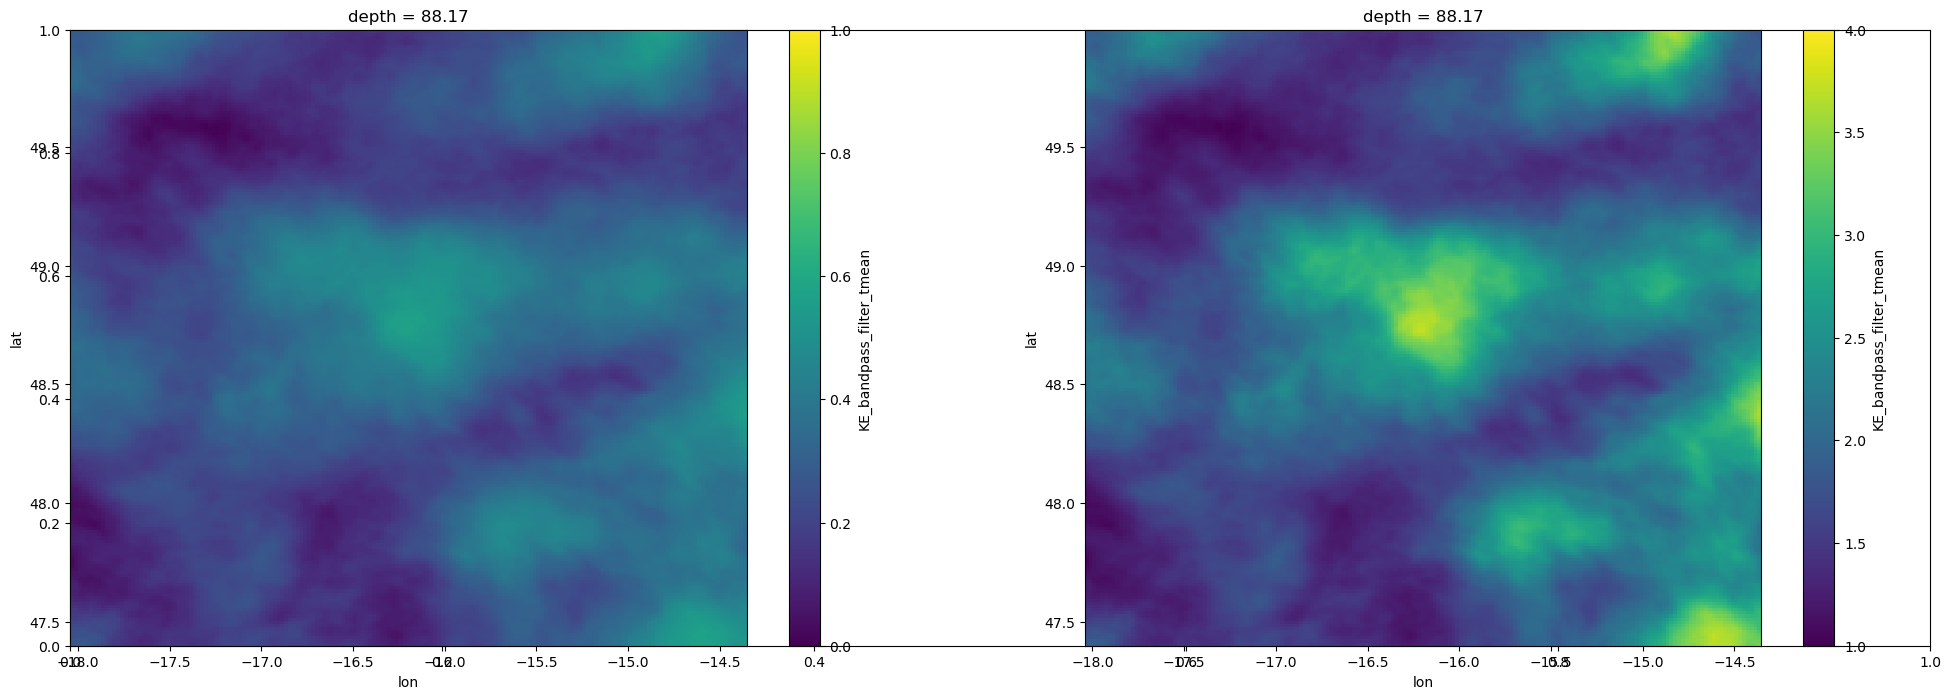

In [22]:
fig, ax = plt.subplots(figsize=(24,8))

ax = plt.subplot(121)
np.log10(ds_m2.KE_bandpass_filter_tmean.isel(depth=20)).plot(vmin=0,vmax=1)

ax = plt.subplot(122)
ds_m2.KE_bandpass_filter_tmean.isel(depth=20).plot(vmin=1,vmax=4)


In [30]:
cluster.close()